Bayesian Optimization: Mean = 0.00040011845622382, Std = 0.00015625295705491785
Random Optimization: Mean = 0.0018999243135393836, Std = 0.0006714110863838734
T-test: t_stat = -7.175041552860537, p_value = 9.22286216025524e-06


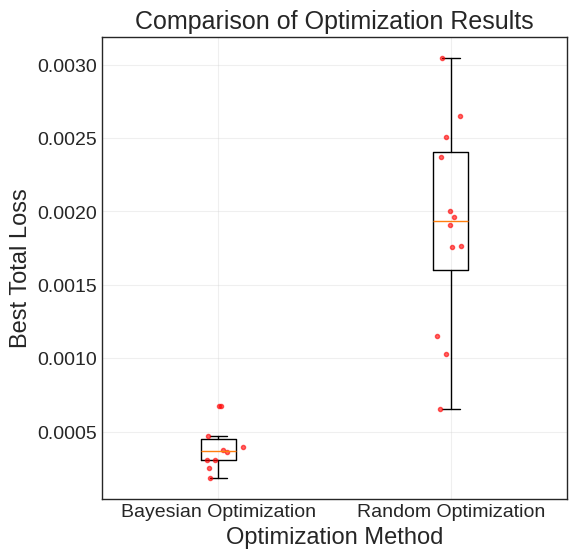

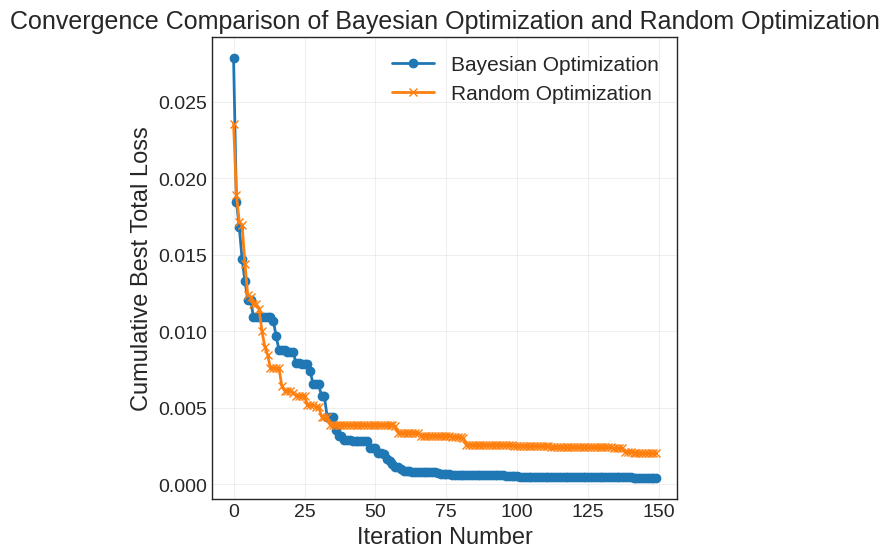

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

num_SOBOL = 0 # the number of SOBOL samples
threshold = 500 # the threshold value for heat_loss
bo_dir = "../experiments/case2_p2o/BO"
random_dir = "../experiments/case2_p2o/RD"

model_indices = [0, 1, 2] 

# get all csv files in the directory
def get_csv_files(directory, num_folders, model_indices):
    csv_files = []
    folder_count = 0

    # get all directories in the directory, sorted by name
    all_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    sorted_dirs = sorted(all_dirs)

    for dir_name in sorted_dirs:
        if "_model_" in dir_name and any(dir_name.endswith(f"_model_{i}") for i in model_indices):
            csv_path = os.path.join(directory, dir_name, "optimization_results.csv")
            if os.path.isfile(csv_path):
                csv_files.append(csv_path)
            folder_count += 1
            if folder_count >= num_folders:
                break

    return csv_files

def get_best_results(files):
    best_results = []
    for file in files:
        df = pd.read_csv(file)
        if not df.empty:
            best_result = df['heat_loss'].min()
            if not np.isnan(best_result):
                best_results.append(best_result)
        else:
            print(f"File {file} is empty.")
    return np.array(best_results)

def get_cumulative_min(files, threshold=500, start_index=0, max_iterations=None):
    """
    Get cumulative minimum of heat_loss from multiple CSV files.
    
    Parameters:
    -----------
    files : list
        List of CSV file paths
    threshold : float
        Maximum allowed value for heat_loss (values above will be capped)
    start_index : int
        Number of initial rows to skip (e.g., SOBOL samples)
    max_iterations : int or None
        Maximum number of iterations to read after start_index.
        If None, read all available data.
        Example: max_iterations=100 will read rows [start_index : start_index+100]
    """
    cumulative_mins = []
    for file in files:
        df = pd.read_csv(file)
        if not df.empty:
            heat_loss = df['heat_loss'].values
            if len(heat_loss) > start_index:
                heat_loss = heat_loss[start_index:]
                
                # Limit to max_iterations if specified
                if max_iterations is not None:
                    heat_loss = heat_loss[:max_iterations]
                
                # set the maximum value of heat_loss to threshold
                if heat_loss[0] >= threshold:
                    heat_loss[0] = threshold
                # set the value of heat_loss to the previous value if it is greater than threshold
                for i in range(1, len(heat_loss)):
                    if heat_loss[i] >= threshold:
                        heat_loss[i] = heat_loss[i-1]
                cumulative_min = np.minimum.accumulate(heat_loss)
                cumulative_mins.append(cumulative_min)
            else:
                print(f"File {file} does not have enough data points.")
        else:
            print(f"File {file} is empty.")
    return cumulative_mins
 
bo_files = get_csv_files(bo_dir, 21, model_indices)
random_files = get_csv_files(random_dir, 21, model_indices)

# get the best results of each experiment
bo_best_results = get_best_results(bo_files)
random_best_results = get_best_results(random_files)

# check if there are valid optimization results
if bo_best_results.size == 0 or random_best_results.size == 0:
    raise ValueError("No valid optimization results found in one or both directories.")

# calculate the mean and standard deviation of the best results
bo_mean = np.mean(bo_best_results)
bo_std = np.std(bo_best_results)
random_mean = np.mean(random_best_results)
random_std = np.std(random_best_results)

print(f"Bayesian Optimization: Mean = {bo_mean}, Std = {bo_std}")
print(f"Random Optimization: Mean = {random_mean}, Std = {random_std}")

# t-test
t_stat, p_value = stats.ttest_ind(bo_best_results, random_best_results, equal_var=False)
print(f"T-test: t_stat = {t_stat}, p_value = {p_value}")





# plot the best results of each experiment
import matplotlib.pyplot as plt
# plt.style.use('_classic_test_patch')

plt.figure(figsize=(6, 6))
plt.boxplot([bo_best_results, random_best_results], labels=['Bayesian Optimization', 'Random Optimization'], showfliers=False)

# Add data points
for i, data in enumerate([bo_best_results, random_best_results]):
    x = np.random.normal(i + 1, 0.04, size=len(data))  # spread the points for better visibility
    plt.plot(x, data, 'r.', alpha=0.6)

plt.xlabel('Optimization Method')
plt.ylabel('Best Total Loss')
plt.title('Comparison of Optimization Results')
plt.grid(True)
plt.show()


max_iter = 150  

bo_cumulative_mins = get_cumulative_min(bo_files, threshold=threshold, start_index=num_SOBOL, max_iterations=max_iter) 
random_cumulative_mins = get_cumulative_min(random_files, max_iterations=max_iter)

# padding the cumulative minimums to the same length
max_len = max(max(len(x) for x in bo_cumulative_mins), max(len(x) for x in random_cumulative_mins))

bo_cumulative_mins_padded = [np.pad(x, (0, max_len - len(x)), 'edge') for x in bo_cumulative_mins]
random_cumulative_mins_padded = [np.pad(x, (0, max_len - len(x)), 'edge') for x in random_cumulative_mins]

# calculate the mean of the cumulative minimums
bo_mean_cumulative_mins = np.mean(bo_cumulative_mins_padded, axis=0)
random_mean_cumulative_mins = np.mean(random_cumulative_mins_padded, axis=0)

# plot the convergence of the cumulative minimums
plt.figure(figsize=(6, 6))
plt.plot(bo_mean_cumulative_mins, label='Bayesian Optimization', marker='o')
plt.plot(random_mean_cumulative_mins, label='Random Optimization', marker='x')
plt.xlabel('Iteration Number')
plt.ylabel('Cumulative Best Total Loss')
plt.legend()
plt.title('Convergence Comparison of Bayesian Optimization and Random Optimization')
plt.grid(True)
plt.show()

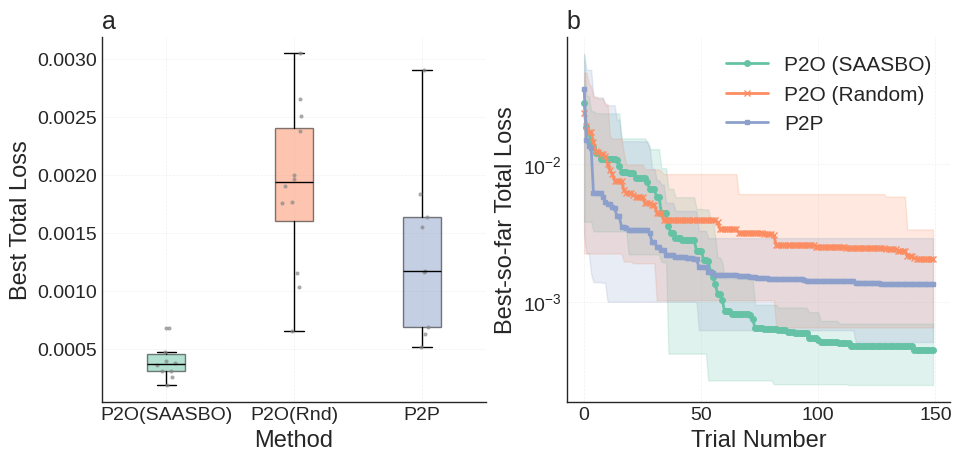

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# —— 1. Style & Font Settings —— #
plt.style.use('seaborn-v0_8-white')
plt.rcParams.update({
    # 'font.family':      'serif',   # Commonly used in academic papers
    'font.size':        16,        # Base font size 16pt
    'axes.titlesize':   18,        # Subplot title size
    'axes.labelsize':   17,        # Axis label size
    'legend.fontsize':  15,
    'xtick.labelsize':  14,
    'ytick.labelsize':  14,
    'axes.linewidth':   1.0,
    'lines.linewidth':  2.0,
    'grid.alpha':       0.3,
})

# —— 2. Unified Color Scheme —— #
color_SAASBO  = '#66C2A5'  # Teal
color_rand   = '#FC8D62'  # Coral Orange
color_LLM    = '#8DA0CB'  # Purple Blue
dot_color    = '#888888'  # Data Point Color

# —— 3. Process LLM Data (Only take the first 120 data points) —— #
llm_dir = "../experiments/case2_p2p"

# Configuration: Group folders belonging to the same run
# Each list represents a complete run, containing one or more folder names
# For example: If a single run is split into multiple folders (due to interruptions), put them in the same list
llm_folder_groups = [
    # Run 1: Possibly split into multiple folders
    ["Control_simulation_results_20251012_123102", "Control_simulation_results_20251012_182532"],
    # Run 2: Single folder
    ["Control_simulation_results_20251012_123105",'Control_simulation_results_20251012_182652'],
    # Run 3: Single folder
    ["Control_simulation_results_20251012_123111","Control_simulation_results_20251012_182532"],
    # More runs can be added...
    ["Control_simulation_results_20251014_132755"],
    ["Control_simulation_results_20251014_132800"],
    ["Control_simulation_results_20251014_132803"],
    ["Control_simulation_results_20251014_132804"],
    ["Control_simulation_results_20251014_132806"],
    ["Control_simulation_results_20251014_132808"],
]

llm_cumulative_mins = []
llm_best_results = []

# Process each group of folders (each group represents a complete run)
for folder_group in llm_folder_groups:
    combined_losses = []
    
    # Read and merge data from all folders in the group
    for folder_name in folder_group:
        folder_path = os.path.join(llm_dir, folder_name)
        log_path = os.path.join(folder_path, "generation_log.csv")
        
        if os.path.exists(log_path):
            df = pd.read_csv(log_path)
            if not df.empty:
                losses = df['Child_Loss'].values
                combined_losses.extend(losses)
            else:
                print(f"File {log_path} has no data.")
        else:
            print(f"Log file not found: {log_path}")
    
    # If data was successfully read
    if len(combined_losses) > 0:
        # Only take the first 120 data points (this number can be modified)
        combined_losses = np.array(combined_losses[:150])
        
        # Handle exceptionally large values (use the same threshold handling rules as SAASBO/Random)
        # If the first value >= threshold, set it to threshold
        if combined_losses[0] >= threshold:
            combined_losses[0] = threshold
        # For subsequent values, if >= threshold, set it to the previous value (maintain continuity)
        for i in range(1, len(combined_losses)):
            if combined_losses[i] >= threshold:
                combined_losses[i] = combined_losses[i-1]
        
        # Calculate cumulative minimum
        cumulative_min = np.minimum.accumulate(combined_losses)
        llm_cumulative_mins.append(cumulative_min)
        llm_best_results.append(cumulative_min[-1])

# Convert to numpy arrays and pad
llm_best_results = np.array(llm_best_results)
if len(llm_cumulative_mins) > 0:
    max_len_llm = max(len(x) for x in llm_cumulative_mins)
    llm_cumulative_mins_padded = [np.pad(x, (0, max_len_llm - len(x)), 'edge') for x in llm_cumulative_mins]
else:
    print("Warning: No LLM data found!")
    llm_cumulative_mins_padded = []

# —— 4. Data Processing (Calculate Min and Max Values) —— #
bo_array    = np.array(bo_cumulative_mins_padded)
rand_array  = np.array(random_cumulative_mins_padded)
llm_array   = np.array(llm_cumulative_mins_padded)

bo_mean     = bo_array.mean(axis=0)
bo_min      = bo_array.min(axis=0)
bo_max      = bo_array.max(axis=0)
rand_mean   = rand_array.mean(axis=0)
rand_min    = rand_array.min(axis=0)
rand_max    = rand_array.max(axis=0)
llm_mean    = llm_array.mean(axis=0)
llm_min     = llm_array.min(axis=0)
llm_max     = llm_array.max(axis=0)

x           = np.arange(len(bo_mean))
x_llm       = np.arange(len(llm_mean))

# —— 5. Plotting —— #
fig, axes = plt.subplots(1, 2,
                         figsize=(9.5, 4.5),
                         sharey=False,
                         constrained_layout=True)

# —— a) Boxplot —— #
ax = axes[0]
box = ax.boxplot([bo_best_results, random_best_results, llm_best_results],
                 labels=['P2O(SAASBO)', 'P2O(Rnd)', 'P2P'],
                 patch_artist=True,
                 showfliers=False)

# Fill color & border
for patch, color in zip(box['boxes'], [color_SAASBO, color_rand, color_LLM]):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
    patch.set_edgecolor('black')
    patch.set_linewidth(1)
for key in ('whiskers','caps','medians'):
    for line in box[key]:
        line.set_color('black')
        line.set_linewidth(1)

# Add scatter points
for i, data in enumerate([bo_best_results, random_best_results, llm_best_results]):
    xs = np.random.normal(i+1, 0.04, size=len(data))
    ax.plot(xs, data, '.', color=dot_color, alpha=0.6, markersize=4)

ax.set_title('a', loc='left')
ax.set_xlabel('Method')
ax.set_ylabel('Best Total Loss')
# ax.set_ylim(0, 0.035)  # Set y-axis range
ax.grid(True, linestyle='--', linewidth=0.5)
# Simplify borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# —— b) Mean + Min-Max Range Curve —— #
ax = axes[1]
ax.plot(x, bo_mean,  label='P2O (SAASBO)',  color=color_SAASBO, marker='o', markersize=4)
ax.fill_between(x, bo_min, bo_max, color=color_SAASBO, alpha=0.2)
ax.plot(x, rand_mean, label='P2O (Random)', color=color_rand,  marker='x', markersize=5)
ax.fill_between(x, rand_min, rand_max, color=color_rand, alpha=0.2)
# Add LLM curve (multiple runs, including min-max range)
ax.plot(x_llm, llm_mean, label='P2P', color=color_LLM, marker='s', markersize=3)
ax.fill_between(x_llm, llm_min, llm_max, color=color_LLM, alpha=0.2)

ax.set_title('b', loc='left')
ax.set_xlabel('Trial Number')
ax.set_ylabel('Best-so-far Total Loss')
# ax.set_ylim(0, 0.02)  # Set y-axis range
# log
ax.set_yscale('log')

ax.legend(loc='upper right', frameon=False)
ax.grid(True, linestyle='--', linewidth=0.5)
# Simplify borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# —— 6. Save & Display —— #
plt.savefig("figure1_combined_SAASBO_vs_random_LLM.png", dpi=300)
plt.show()